In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions
using TwoFAST, LaTeXStrings, LsqFit

In [3]:
FILE_F_MAP = "../data/F_REFERENCE.txt"
#FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_PS = "file_pk.txt"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
#FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 20,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, 
  N = 1024, fit_min = 1.0, fit_max= 4.0, con=true)
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP)#, FILE_IS)

GaPSE.parameters_used(stdout, cosmo)

l_si, l_b, l_a = -2.148098687711197 , -21.126980922934393 , 0.0012747666192116014
[-3.2331580993168266e18, -3.054589364543789e18, -2.885883059030001e18, -2.7264944764973916e18, -2.575908995033713e18, -2.4336404155198264e18, -2.2992293918263877e18, -2.1722419477115533e18, -2.0522680756309594e18, -1.9389204129361078e18, -1.8318329911868352e18, -1.730660054539889e18, -1.6350749433983388e18, -1.5447690397175278e18, -1.4594507705622996e18, -1.3788446666981258e18, -1.30269047317667e18, -1.2307423090441452e18, -1.1627678734592916e18, -1.0985476956578348e18, -1.0378744263417112e18, -9.80552168205218e17, -9.263958434364571e17, -8.752305961519506e17, -8.268912278350936e17, -7.812216639555462e17, -7.38074450047477e17, -6.973102756196527e17, -6.587975243601517e17, -6.22411849183469e17, -5.88035770747984e17, -5.555582981474504e17, -5.2487457055188134e17, -4.9588551864074963e17, -4.684975447354027e17, -4.4262222059788314e17, -4.181760019204552e17, -3.950799585840151e17, -3.7325951981443136e17, -3.52

In [4]:
tab_pk = readdlm("../data/WideA_ZA_pk.dat", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

In [5]:
tab_casto_Is = readdlm("tab_xi.txt", comments=true);
casto_ss = convert(Vector{Float64}, tab_casto_Is[2:end,1]);

In [6]:
kmin = min(ks...)
kmax = 10.
σ_0, σ_0_err  = quadgk(q -> PK(q) * q^2 / (2 * π^2), kmin, kmax)
σ_1, σ_1_err = quadgk(q -> PK(q) * q / (2 * π^2), kmin, kmax)
σ_2, σ_2_err = quadgk(q -> PK(q) / (2 * π^2), kmin, kmax)
σ_3, σ_3_err = quadgk(q -> PK(q) / (2 * π^2 * q), kmin, kmax)

println("σ_0 = $σ_0 \t σ_0_err = $σ_0_err")
println("σ_1 = $σ_1 \t σ_1_err = $σ_1_err")
println("σ_2 = $σ_2 \t σ_2_err = $σ_2_err")
println("σ_3 = $σ_3 \t σ_3_err = $σ_3_err")

σ_0 = 18.584280735800895 	 σ_0_err = 2.7176219709323934e-7
σ_1 = 15.755562804134984 	 σ_1_err = 2.2202217648398248e-7
σ_2 = 101.06362213588237 	 σ_2_err = 1.4978881322947474e-6
σ_3 = 3735.1445439219237 	 σ_3_err = 4.569273746514446e-5


In [7]:
#ss = 10 .^ range(-6, 2, 100);
ss = casto_ss;

In [8]:
my_I00s = [cosmo.tools.I00(s) for s in ss];
my_I20s = [cosmo.tools.I20(s) for s in ss];
my_I40s = [cosmo.tools.I40(s) for s in ss];
my_I02s = [cosmo.tools.I02(s) for s in ss];
my_I22s = [cosmo.tools.I22(s) for s in ss];
my_I31s = [cosmo.tools.I31(s) for s in ss];
my_I13s = [cosmo.tools.I13(s) for s in ss];
my_I11s = [cosmo.tools.I11(s) for s in ss];

In [9]:
function I_l_n(s, PK; l=0, n=0, en = 1e6, kwargs...)
    first = quadgk(q -> en * (sphericalbesselj(l, s*q) - 1) * PK(q) * q^2 / (2 * π^2 * (q*s)^n), 
        kmin, kmax; kwargs...)
    second = quadgk(q -> en * PK(q) * q^2 / (2 * π^2 * (q*s)^n), 
        kmin, kmax; kwargs...)
    return ((first[1] + second[1]) / en, first[2]/en)
end

I_l_n (generic function with 1 method)

In [10]:
true_I00s = [I_l_n(s, PK; l=0, n=0, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I20s = [I_l_n(s, PK; l=2, n=0, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I40s = [I_l_n(s, PK; l=4, n=0, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I02s = [I_l_n(s, PK; l=0, n=2, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I22s = [I_l_n(s, PK; l=2, n=2, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I31s = [I_l_n(s, PK; l=3, n=1, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I13s = [I_l_n(s, PK; l=1, n=3, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I11s = [I_l_n(s, PK; l=1, n=1, atol=1e-6, rtol=1e-3)[1] for s in ss];

In [11]:
casto_I00s = convert(Vector{Float64}, tab_casto_Is[2:end,2]);
casto_I20s = convert(Vector{Float64}, tab_casto_Is[2:end,3]);
casto_I40s = convert(Vector{Float64}, tab_casto_Is[2:end,4]);
casto_I02s = convert(Vector{Float64}, tab_casto_Is[2:end,5]) ./ casto_ss .^2;
casto_I22s = convert(Vector{Float64}, tab_casto_Is[2:end,6]) ./ casto_ss .^2;
casto_I31s = convert(Vector{Float64}, tab_casto_Is[2:end,7]) ./ casto_ss;
casto_I11s = convert(Vector{Float64}, tab_casto_Is[2:end,8]) ./ casto_ss;

In [12]:
my_vec = [my_I00s, my_I20s, my_I40s, my_I02s, my_I22s, my_I31s,
             my_I11s, my_I13s];
casto_vec = [casto_I00s, casto_I20s, casto_I40s, casto_I02s, casto_I22s, 
            casto_I31s, casto_I11s ];

true_vec = [true_I00s, true_I20s, true_I40s, true_I02s, true_I22s, true_I31s,
            true_I13s, true_I11s, true_I13s];

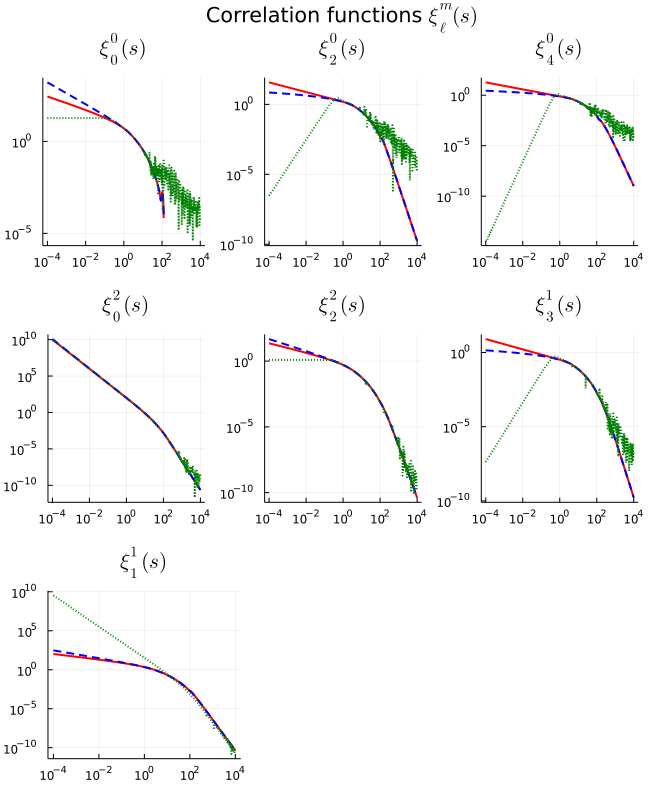

In [13]:
ξs_names = [L"$\xi_{0}^{0}(s)$", L"$\xi_{2}^{0}(s)$", L"$\xi_{4}^{0}(s)$",
            L"$\xi_{0}^{2}(s)$", L"$\xi_{2}^{2}(s)$", L"$\xi_{3}^{1}(s)$",
            L"$\xi_{1}^{1}(s)$"]
ps = [plot() for i in 1:7]

title = plot(title = "Correlation functions "* L"$\xi_\ell^m(s)$", grid=false, showaxis = false, bottom_margin = -50Plots.px, ticks=false)
xs = ss
for i in 1:7
    c_ys = casto_vec[i]
    m_ys = my_vec[i]
    t_ys = true_vec[i]
    ps[i] = plot(
        [xs[c_ys.>0], xs[m_ys.>0], xs[t_ys.>0]], 
        [c_ys[c_ys.>0], m_ys[m_ys.>0],  t_ys[t_ys.>0]], 
        lw=2, lc=["red" "blue" "green"], ls=[:solid :dash :dot],
        title=ξs_names[i], legend=false,
        xaxis=:log, yaxis=:log)
end

l = @layout [A{0.05h}; a b c ; d e f; g _ _ ]
plot(title, ps..., layout=l, size=(650,800))

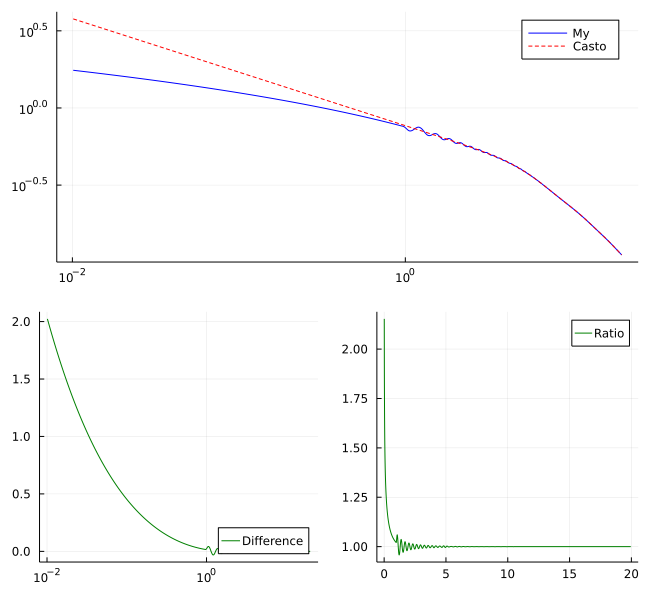

In [14]:
ind = 3

x_min = 1e-2
x_max = 20

new_ss = ss[x_min.< ss .< x_max]
my_ys = my_vec[ind][x_min.< ss .< x_max]
casto_ys = casto_vec[ind][x_min.< ss .< x_max]

p1 = plot([new_ss, new_ss], [my_ys, casto_ys], 
    xscale=:log10, yscale=:log10,
    label=["My" "Casto"], lc=[:blue :red], ls=[:solid :dash])
p2 = plot(new_ss, casto_ys .- my_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(new_ss, casto_ys ./ my_ys, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [15]:
power_law(x, si, a, b) = a .+ b .* x .^ si
 
function power_law_from_data(xs, ys, p0, x1::Number, x2::Number; con=false)
    @assert length(xs) == length(ys) "xs and ys must have same length"
    #Num = length(xs)
    new_xs = xs[x1 .< xs .< x2]
    new_ys = ys[x1 .< xs .< x2]
    
    #si = mean_spectral_index(xs, ys; N=N, con=con)
    si, b, a =
        if con ==false
            @assert length(p0) == 2 " si,b to be fitted, so length(p0) must be 2!"
            vec = coef(curve_fit((x,p)-> power_law(x, p[1], p[2], 0.0), 
                        new_xs, new_ys, p0 ))
            vcat(vec, 0.0)
        else
            @assert length(p0) == 3 " si,b,a to be fitted, so length(p0) must be 3!"
             coef(curve_fit((x,p) -> power_law(x, p[1], p[2], p[3]), 
                    new_xs, new_ys, p0))
        end
 
    return si, b, a
end

function expand_left_log(xs, ys; lim=1e-8, fit_min = 2.0, 
        fit_max = 10.0,  p0 = [-1.0, 1.0, 0.0], con=true)
    
    si, b, a = power_law_from_data(
          xs[fit_min .< xs .< fit_max], ys[fit_min .< xs .< fit_max],
          p0, fit_min, fit_max; con = con)

    i = findfirst(x -> x > fit_min, xs) - 1
    f = xs[begin] / xs[begin+1]

    new_left_xs = unique(10 .^ range(log10(lim), log10(xs[i]), step = -log10(f)))
    new_left_ys = [power_law(x, si, b, a) for x in new_left_xs]

    return new_left_xs, new_left_ys
end

function expanded_Iln(PK, l, n; lim=1e-4, N = 1024, kmin = 1e-4, kmax = 1e3, s0 = 1e-3,
          fit_min = 2.0, fit_max = 10.0,  p0 = [-1.0, 1.0, 0.0], con = true)

     rs, xis = xicalc(PK, l, n; N = N, kmin = kmin, kmax = kmax, r0 = s0)

     new_left_rs, new_left_Is = expand_left_log(rs, xis; lim=lim, fit_min = fit_min, 
        fit_max = fit_max,  p0 = p0, con=con)

     new_rs = vcat(new_left_rs, rs[rs .> fit_min ])
     new_Is = vcat(new_left_Is, xis[rs .> fit_min ])

     return new_rs, new_Is
end

expanded_Iln (generic function with 1 method)

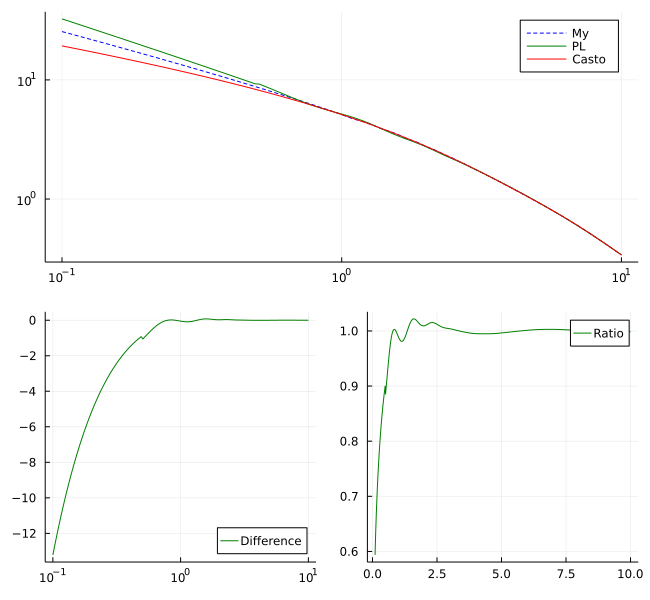

In [16]:
ind = 1

x_min = 1e-1
x_max = 10

fit_min = 0.5
fit_max = 3.0

new_ss = ss[x_min.< ss .< x_max]
my_ys = my_vec[ind][x_min.< ss .< x_max]
casto_ys = casto_vec[ind][x_min.< ss .< x_max]

pl_xs, orig_pl_ys = expanded_Iln(PK, 0, 0; N = 1024, kmin = 1e-6, kmax = 10, s0 = 1e-1,
          fit_min = fit_min, fit_max = fit_max,  p0 = [-1.0, 1.0, 0.0], con = true)
spline = Spline1D(pl_xs, orig_pl_ys)
pl_ys = spline.(new_ss)

p1 = plot([new_ss, new_ss, new_ss], [my_ys, pl_ys, casto_ys], 
    xscale=:log10, yscale=:log10,
    label=["My" "PL" "Casto"], lc=[:blue :green :red], ls=[:dash :solid :solid])
p2 = plot(new_ss, casto_ys .- pl_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(new_ss, casto_ys ./ pl_ys, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [17]:
r00, I00 = xicalc(PK, 0, 0; N=1024, kmin=1e-12, kmax= 1e1, r0=1e-1)
r00[begin+1] / r00[begin], r00[end], r00[begin]

(1.029663487107312, 9.711910857491425e11, 0.1)

\begin{split}
     &J_{40}(s_1, s_2, y, \chi_1, \chi_2)  = 
          \frac{
                    9 \mathcal{H}_0^4 \Omega_{M0}^2 D(\chi_1) D(\chi_2) \chi^4
          }{    a(\chi_1) a(\chi_2) s_1 s_2} 
          (s_2 \mathcal{H}(\chi_2) \mathcal{R}(s_2) (f(\chi_2)-1) - 1) 
          (s_1 \mathcal{H}(\chi_1) \mathcal{R}(s_1) (f(\chi_1)-1) - 1)\\[5pt]
     &\tilde{I}^4_0 (s) = \int_0^\infty \frac{\mathrm{d}q}{2\pi^2} 
          q^2 \, P(q) \, \frac{j_0(q s) - 1}{(q s)^4}
\end{split}

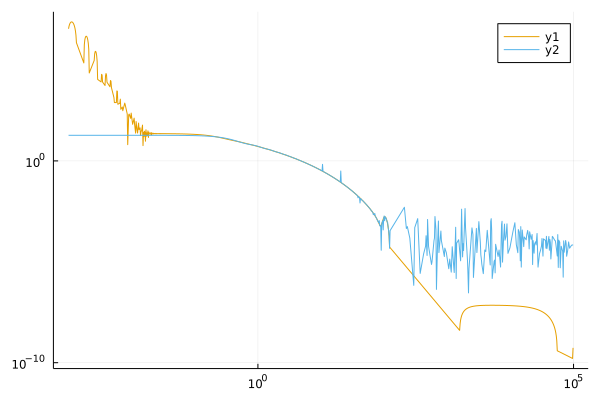

In [18]:
r00, I00 = xicalc(PK, 0, 0; N=1024, r0=1e-3)
quad_I00 = [quadgk(q->sphericalbesselj(0, s*q) * PK(q) * q^2 / (2.0 * π^2), 
        1e-4, 10; atol=1e-4, rtol=1e-3)[1] for s in r00]
plot(r00[I00.>0], I00[I00.>0], xaxis=:log, yaxis=:log)
plot!(r00[quad_I00.>0], quad_I00[quad_I00.>0])

\begin{equation}
    I^n_l(s) = \int \frac{dq}{2\pi^2} q^2P(q) \frac{j_l(qs)}{(qs)^n}
\end{equation}

\begin{equation}
    \tilde{I}^4_0 (s) = \int \frac{dq}{2\pi^2} q^2P(q) \frac{j_0(qs) - 1}{(qs)^4}
\end{equation}

In [26]:
function func_I04_tilde(PK, s, kmin, kmax; kwargs...)
     quadgk(lq -> (sphericalbesselj(0, s * exp(lq)) - 1.0) * PK(exp(lq)) * exp(lq)^(-1)/ (2.0 * π^2 * (s)^4),
          log(kmin), log(kmax); kwargs...)
end

func_I04_tilde (generic function with 1 method)

In [31]:
func_I04_tilde(PK, 1, kmin, kmax)

(-16.736717210739467, 2.4227160651872966e-7)

In [32]:
tab_mattia_I04_tildes = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/I40_tilde.txt");
mattia_ss = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,1]);
mattia_I04_tildes = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,2]);